In [1]:
%run /eos/project/m/mte/myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-514.10.2.el7.x86_64-x86_64-with-redhat-6.7-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering
Your IP is 172.17.0.22
2017-08-15 13:53:16


In [2]:
# let's start with the good data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.07.31/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 616 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.07.31/2017.07.31.18.10.01.814.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.07.31/2017.08.01.00.19.37.632.mat


## Load the data

In [3]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_68_H_ROT.Acquisition.value.projDataSet1','PR_BWS_68_H_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples'],verbose=False)

## Intensity

In [4]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][1780]/np.max(x) )

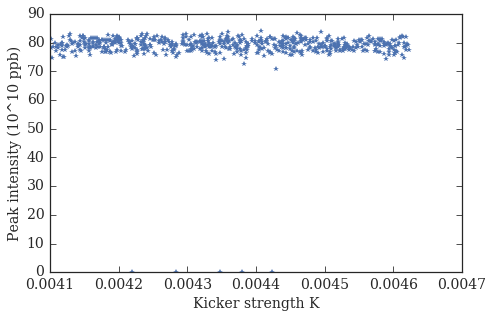

In [5]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')

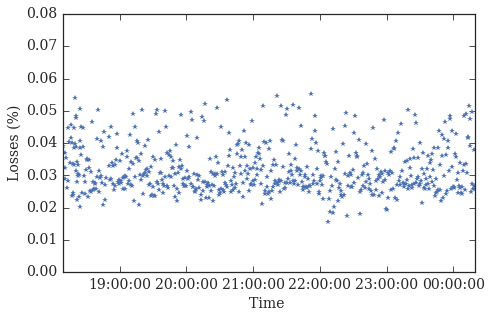

In [6]:
plt.plot(myDataFrame['Losses_perc'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,.08))
plt.xlabel('Time ')
plt.ylabel('Losses (%)')

## BPMs

In [7]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
#turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
#add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [9]:
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

deltaXrms = []
delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    deltaXrms.append( np.sqrt( ( np.sum((mySeries2.values[x] - mySeries1.values[x])**2) )/BPM_n ) )
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )

#find the nan value, which is where the routine crashes
#for x in range(len(deltaXrms)):
#    if math.isnan(deltaXrms[x]) :
#        print x
#####MANUALLY CHECKED, ARE BAD SHOTS IN OVERFLOW        

myDataFrame['delta_2turns'] = deltaXrms
myDataFrame['Orbit_dev_RMS'] = delta_1st_orbit

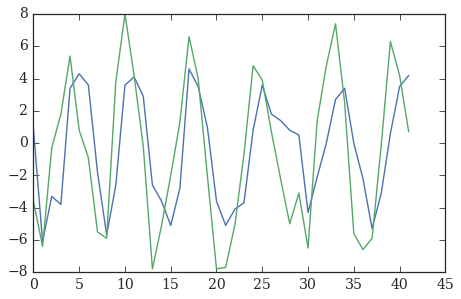

In [10]:
plt.plot(mySeries1.values[0])
plt.plot(mySeries2.values[0])
plt.show()

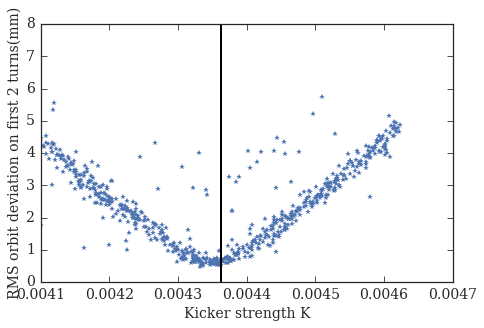

In [11]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['delta_2turns'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
plt.axvline(x=0.004362000000000, ymin=0, ymax = 8, linewidth=2, color='k')

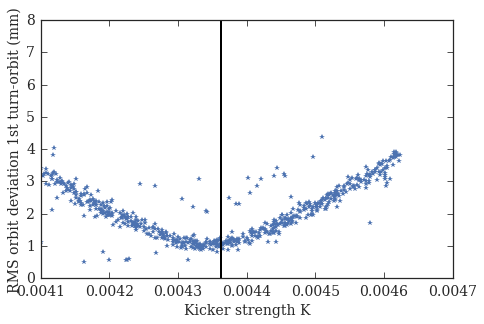

In [12]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Orbit_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
plt.axvline(x=0.004362000000000, ymin=0, ymax = 8, linewidth=2, color='k')

### Wire scanner

In [13]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS68_position'] = myDataFrame['PR_BWS_68_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS68_position_idx'] = myDataFrame['PR_BWS_68_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [14]:
#instantiate an array object for the result in the frame
myDataFrame['BWS68_data'] = myDataFrame['BWS68_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS68_data'].iloc[r] = np.interp(pos, myDataFrame['BWS68_position'].iloc[r], myDataFrame['PR_BWS_68_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS68_position_idx'].iloc[r]])  

/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas-0.19.0-py2.7-linux-x86_64.egg/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results'] = myDataFrame['BWS68_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma'] = myDataFrame['WS_fit_results'].apply(lambda x: x[0][-1])

### Tomogram

!!! For some reason the tomogram stopped at 21.20 while the rest of the acquisition kept going on up to after midnight !!!

In [16]:
#associate the tomogram data with timestamp
myTsDataFrame = pnd.read_csv('/eos/user/e/esenes/Injection_missteering/tomo_ts_lst.csv',header=None)

In [36]:
bin_start = 134 #18:09:20 of 31.07.2017
ts_aqn = myTsDataFrame.values[bin_start:,1]

In [42]:
ts_test[1]

'20170731_16:28:37'

In [65]:
def str_to_datetime(ts_test) :
    'convert single timestamp to a datetime object'
    yyyy = int(ts_test[1][0:4])
    mm = int(ts_test[1][4:6])
    dd = int(ts_test[1][6:8])
    HH = int(ts_test[1][9:11])
    MM = int(ts_test[1][12:14])
    SS = int(ts_test[1][15:17])
    return pnd.datetime(yyyy,mm,dd,HH,MM,SS)

In [67]:
myTsDataFrame['tsObj'] = myTsDataFrame['1']

,0,1
0,C1400b4_001,20170731_16:27:56
1,C1400b4_002,20170731_16:28:37
2,C1400b4_003,20170731_16:29:17
3,C1400b4_004,20170731_16:29:58
4,C1400b4_005,20170731_16:30:39
5,C1400b4_006,20170731_16:31:20
6,C1400b4_007,20170731_16:32:01
7,C1400b4_008,20170731_16:32:41
8,C1400b4_009,20170731_16:33:22
9,C1400b4_010,20170731_16:34:03


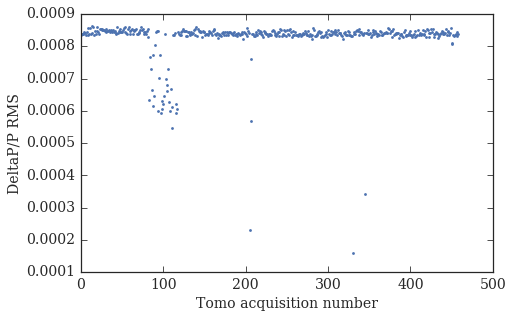

In [19]:
#get the RMS deltaP/P from the tomogram analysis
myNewDataFrame = pnd.read_csv('/eos/user/e/esenes/Injection_missteering/tomo_out.csv',encoding='utf-8',sep='\t',index_col='Unnamed: 0')
dpprms = myNewDataFrame.loc['deltaP_P_RMS','C1400b4_001':'C1400b4_465']
deltaP_P_rms = dpprms.values
plt.plot(deltaP_P_rms,'.')
plt.xlabel('Tomo acquisition number')
plt.ylabel('DeltaP/P RMS')

In [20]:
myNewDataFrame

,C1400b4_001,C1400b4_002,C1400b4_003,C1400b4_004,C1400b4_005,C1400b4_006,C1400b4_007,C1400b4_008,C1400b4_009,C1400b4_010,...,C1400b4_456,C1400b4_457,C1400b4_458,C1400b4_459,C1400b4_460,C1400b4_461,C1400b4_462,C1400b4_463,C1400b4_464,C1400b4_465
Bdot_T_per_s,0.00214285714286,-0.00178571428573,0.00178571428573,-9.06304509898e-15,1.8126090198e-14,0.00107142857142,0.00285714285715,0.00357142857144,-0.00178571428572,-9.06304509898e-15,...,0.00107142857144,0.00285714285715,-0.00214285714287,0.00214285714286,-9.06304509898e-15,0.00214285714286,-0.00107142857142,1.8126090198e-14,-9.06304509898e-15,1.8126090198e-14
PLSUSER,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,...,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering,MD8=MD2586_missteering
t_ns,"[-98.371, -97.371, -96.371, -95.371, -94.371, ...","[-98.511, -97.511, -96.511, -95.511, -94.511, ...","[-99.536, -98.536, -97.536, -96.536, -95.536, ...","[-99.094, -98.094, -97.094, -96.094, -95.094, ...","[-98.826, -97.826, -96.826, -95.826, -94.826, ...","[-98.955, -97.955, -96.955, -95.955, -94.955, ...","[-99.182, -98.182, -97.182, -96.182, -95.182, ...","[-98.075, -97.075, -96.075, -95.075, -94.075, ...","[-98.511, -97.511, -96.511, -95.511, -94.511, ...","[-98.491, -97.491, -96.491, -95.491, -94.491, ...",...,"[-101.167, -100.167, -99.167, -98.167, -97.167...","[-99.642, -98.642, -97.642, -96.642, -95.642, ...","[-100.202, -99.202, -98.202, -97.202, -96.202,...","[-99.201, -98.201, -97.201, -96.201, -95.201, ...","[-100.737, -99.737, -98.737, -97.737, -96.737,...","[-99.2, -98.2, -97.2, -96.2, -95.2, -94.2, -93...","[-99.229, -98.229, -97.229, -96.229, -95.229, ...","[-99.422, -98.422, -97.422, -96.422, -95.422, ...","[-99.198, -98.198, -97.198, -96.198, -95.198, ...","[-100.013, -99.013, -98.013, -97.013, -96.013,..."
particleMass_eV,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,...,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0,938272310.0
yat0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
dEbin,55331.0,55358.0,55622.0,55355.0,55463.0,55512.0,55521.0,55179.0,55451.0,55554.0,...,55656.0,52789.0,52495.0,55425.0,55293.0,55217.0,55343.0,55432.0,55429.0,55399.0
beta,0.915124034884,0.915094679363,0.915094679363,0.915094679363,0.915124034884,0.915109358942,0.915109358942,0.915109358942,0.915124034884,0.915094679363,...,0.915124034884,0.915109358942,0.915094679363,0.915094679363,0.915094679363,0.915124034884,0.915094679363,0.915124034884,0.915094679363,0.915124034884
deltaP_P_RMS,0.00083520050825,0.000839234207378,0.000837614995755,0.000837169837016,0.000845499540331,0.000841758513923,0.000835917327273,0.000844087541433,0.000836340535243,0.000857589326862,...,0.00085569413936,0.000811515082037,0.000806621714413,0.000835190076456,0.000832488270425,0.00083528845081,0.000838516813868,0.000844269336367,0.000831751422064,0.000837503783569
machineRadius_m,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
rmsemittance,0.166344140755,0.167150347841,0.165495220193,0.166617797995,0.169183727239,0.167885490382,0.165038299938,0.170375471783,0.16609935876,0.175046097251,...,0.172949558004,0.165380120669,0.163709283608,0.166036909079,0.164245902805,0.166374560043,0.167243114489,0.168923516871,0.16386594084,0.166376400244


In [21]:
#### Still we are running using the measured RMS deltaP/P instead of the tomogram

In [22]:
def normalised_emittance(sig):
    "Calculate the normalised emittance, where sig is in mm"
    betar = 0.916
    D = 2.330216464
    dp = 0.846e-3
    betax = 13.00860302
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    
    return emi*1e6

In [23]:
myDataFrame['WS_emittance'] = myDataFrame['WS_sigma'].apply(lambda x: normalised_emittance(x))

(0, 6, 0, 2)

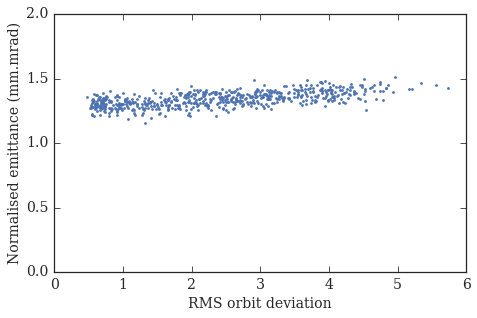

In [24]:
plt.plot(myDataFrame['delta_2turns'], myDataFrame['WS_emittance'],'.')
plt.xlabel('RMS orbit deviation')
plt.ylabel('Normalised emittance (mm.mrad)')

# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
plt.axis((0,6,0,2))

(0.0041000000000000003, 0.0047000000000000002, 1, 1.6)

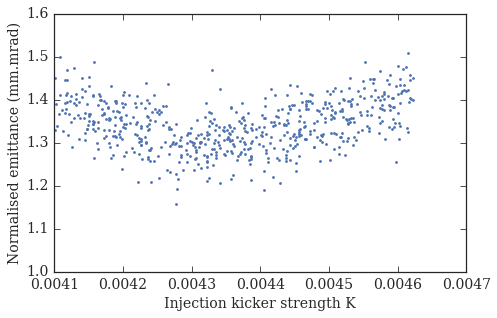

In [25]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'], myDataFrame['WS_emittance'],'.')
plt.xlabel('Injection kicker strength K')
plt.ylabel('Normalised emittance (mm.mrad)')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,1.6))

(0.0041000000000000003, 0.0047000000000000002, 3.2, 3.6)

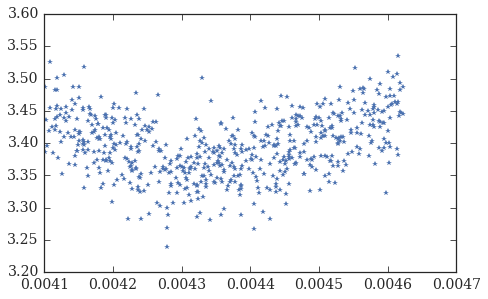

In [26]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_sigma'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,3.2,3.6))

In [2]:
plt.plot(((myDataFrame['Orbit_dev_RMS'].values)**2),  (myDataFrame['WS_emittance']-1.3)/1.3,'*')

x1,x2,y1,y2 = plt.axis()
plt.axis((-2,30,-0.2,.2))

plt.plot([-2,2],[-2/(3.35**2),2/(3.35)**2],'k-')
plt.plot([0,20],[0,2/(3.35)**2],'r-')

plt.show()


NameError: name 'myDataFrame' is not defined

In [ ]:
### still TODOs:
# - make that tomogram script work --> use correct dp/p for the sc
# - play with RMS orbit

In [ ]:
#RMS orbit part